In [1]:
import datetime
from functools import partial
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from typing import List, Callable
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from itertools import product
from collections import Counter
import vectorbt as vbt
from scipy.optimize import minimize
from pandas.tseries.offsets import DateOffset
import numpy as np

In [2]:
class Labeler:
    def __init__(self, name):
        """
        Initialize the labeler.

        Args:
        name (str): The name of the labeler.
        """
        self.name = name

    def fit(self, data):
        """
        Fit the labeler to the data.

        This method should be overridden by subclasses to implement
        the actual fitting logic.

        Args:
        data (any): The data to fit the labeler to.
        """
        raise NotImplementedError("Subclasses must implement this method.")

    def transform(self, data):
        """
        Transform the data into labels.

        This method should be overridden by subclasses to implement
        the actual transformation logic.

        Args:
        data (any): The data to transform into labels.

        Returns:
        any: The labels.
        """
        raise NotImplementedError("Subclasses must implement this method.")

class TripleBarrierLabeler(Labeler):
    def __init__(self, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=7, min_trend_days=2, barrier_type='volatility', touch_type="HL", up_label=2, neutral_label=1, down_label=0):
        """
        Initialize the labeler.
        """
        super().__init__(name="triple barrier labeling")
        self.volatility_period = volatility_period
        self.upper_barrier_factor = upper_barrier_factor
        self.lower_barrier_factor = lower_barrier_factor
        self.vertical_barrier = vertical_barrier
        self.min_trend_days = min_trend_days
        self.barrier_type = barrier_type
        self.touch_type = touch_type
        self.up_label = up_label
        self.down_label = down_label
        self.neutral_label = neutral_label

    def calculate_barriers(self, df, i, window):
        """calculate the barriers based on either volatility or returns of the backward window

        Args:
            df (pd.DataFrame): Data
            i (pd.index): the index of the beginning of the window
            window (int): window size

        Returns:
            df: Data including barriers for the forward window
        """
        end_window = min(i+window, len(df)-1)  # Ensure the window does not exceed the dataframe

        # Calculate the mean volatility or daily returns over the volatility_period
        if self.barrier_type == 'volatility':
            current_value = df.loc[i, 'volatility']
        elif self.barrier_type == 'returns':
            current_value = df.loc[i, 'daily_returns']
        else:
            raise ValueError("Invalid barrier_type. Choose either 'volatility' or 'returns'")

        df.loc[i:end_window, 'upper_barrier'] = df.loc[i, 'close'] + (df.loc[i, 'close'] * current_value * self.upper_barrier_factor)
        df.loc[i:end_window, 'lower_barrier'] = df.loc[i, 'close'] - (df.loc[i, 'close'] * current_value * self.lower_barrier_factor)
        return df

    def label_observations(self, df, origin, i, label):
        df.loc[origin:i+1, 'label'] = label
        return df

    def get_daily_vol(self, close, span0=100):
        """
        Calculate the daily volatility of closing prices.

        Parameters:
        - close: A pandas Series of closing prices.
        - span0: The span for the EWM standard deviation.

        Returns:
        - A pandas Series of daily volatility estimates.
        """
        # Find the start of the previous day for each day
        prev_day_start = close.index.searchsorted(close.index - pd.Timedelta(days=1))
        prev_day_start = prev_day_start[prev_day_start > 0]

        # Create a series with the start of the previous day for each day
        prev_day_start = pd.Series(close.index[prev_day_start - 1], index=close.index[close.shape[0] - prev_day_start.shape[0]:])

        # Calculate daily returns
        daily_returns = close.loc[prev_day_start.index] / close.loc[prev_day_start.values].values - 1

        # Calculate EWM standard deviation of daily returns
        daily_vol = daily_returns.ewm(span=span0).std()

        return daily_returns, daily_vol

    def fit(self, sdf):
        df = sdf.copy()
        # Calculate daily returns and volatility
        df['daily_returns'], df['volatility'] = self.get_daily_vol(df.close, self.volatility_period)

        df = df.reset_index()
        # Initialize label and window start
        df['label'] = self.neutral_label
        df['window_start'] = False

        self.data = df

    def transform(self):
        """
        Transform the data into labels.

        Returns:
        pd.DataFrame: The labels.
        """
        window = self.vertical_barrier
        origin = 0
        touch_upper = lambda high, barrier: high >= barrier
        touch_lower = lambda low, barrier: low <= barrier
        # For each observation
        for i in range(0, len(self.data)):
            # Define your barriers at the beginning of each window
            if i == origin:
                self.data = self.calculate_barriers(self.data, i, window)
                self.data.loc[i, 'window_start'] = True  # Mark the start of the window

            # one of the conditions were met
            if touch_upper(self.data.loc[i, "high" if self.touch_type == 'HL' else 'close'], self.data.loc[i, "upper_barrier"]):
                if (i - origin > self.min_trend_days):
                    # label the observations
                    self.data = self.label_observations(self.data, origin, i, self.up_label)
                    # set new origin
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index
                    # reset window
                    window = self.vertical_barrier
            elif touch_lower(self.data.loc[i, "low" if self.touch_type == 'HL' else 'close'], self.data.loc[i, "lower_barrier"]):
                if (i - origin > self.min_trend_days):
                    # label the observations
                    self.data = self.label_observations(self.data, origin, i, self.down_label)
                    # set new origin
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index
                    # reset window
                    window = self.vertical_barrier

            # none of the conditions were met
            else:
                if window > 0:
                    # reduce window size by one
                    window = window - 1
                else:
                    # reset window
                    window = self.vertical_barrier
                    # label neutral from origin to origin + window
                    self.data.loc[origin:min(origin+window, len(self.data)-1), 'label'] = self.neutral_label  # Ensure the window does not exceed the dataframe
                    # set origin to the next id
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index

        self.data = self.data.set_index("timestamp")
        return self.data

def optimize_parameters(price_df, param_grid, initial_capital=100000, num_starts=10, optimization_interval='6M'):
    if optimization_interval is None:
        # Use the whole dataset for optimization
        best_params, best_sharpe_ratio, best_net_profit = tune_hyperparameters_scipy(price_df, param_grid, initial_capital, num_starts)
        return pd.DataFrame([{
            'start': price_df.index[0],
            'end': price_df.index[-1],
            'params': best_params,
            'sharpe_ratio': best_sharpe_ratio,
            'net_profit': best_net_profit
        }])
    else:
        # Optimize parameters at specified intervals
        intervals = pd.date_range(start=price_df.index[0], end=price_df.index[-1], freq=optimization_interval)
        optimized_params = []

        for start, end in zip(intervals[:-1], intervals[1:]):
            interval_df = price_df.loc[start:end]
            best_params, best_sharpe_ratio, best_net_profit = tune_hyperparameters_scipy(interval_df, param_grid, initial_capital, num_starts)
            optimized_params.append({
                'start': start,
                'end': end,
                'params': best_params,
                'sharpe_ratio': best_sharpe_ratio,
                'net_profit': best_net_profit
            })

        return pd.DataFrame(optimized_params)

def tune_hyperparameters_scipy(price_df, param_grid, initial_capital=100000, num_starts=10):
    best_sharpe_ratio, best_net_profit, best_params = -np.inf, -np.inf, None

    param_space = [
        param_grid['volatility_period'],
        param_grid['upper_barrier_factor'],
        param_grid['lower_barrier_factor'],
        param_grid['vertical_barrier'],
        param_grid['barrier_type'],
        param_grid['touch_type']
    ]

    bounds = [(0, len(space) - 1) for space in param_space]

    def bounds_to_params(x):
        return {key: space[int(idx)] for key, space, idx in zip(param_grid.keys(), param_space, x)}

    def objective_wrapper(x):
        params = bounds_to_params(x)
        return sharpe_ratio_objective(params, price_df, initial_capital)

    for _ in tqdm(range(num_starts), desc="Optimizing"):
        initial_guess = [np.random.randint(len(space)) for space in param_space]
        result = minimize(objective_wrapper, initial_guess, method='SLSQP', bounds=bounds)

        if result.success and -result.fun > best_sharpe_ratio:
            best_sharpe_ratio = -result.fun
            best_params = bounds_to_params(result.x)
            labeler = TripleBarrierLabeler(**best_params)
            labeler.fit(price_df)
            labeled_df = labeler.transform()
            portfolio_values = buy_and_hold(labeled_df['close'], labeled_df['label'], labeled_df["upper_barrier"], labeled_df["lower_barrier"], initial_capital)
            best_net_profit = portfolio_values.iloc[-1] - initial_capital

    return best_params, best_sharpe_ratio, best_net_profit

def sharpe_ratio_objective(params, price_df, initial_capital):
    labeler = TripleBarrierLabeler(**params)
    labeler.fit(price_df)
    labeled_df = labeler.transform()
    labeled_df.set_index(price_df.index, inplace=True)
    sharpe_ratio = strategize_and_measure(labeled_df, init_capital=initial_capital)
    return -sharpe_ratio  # Minimize negative Sharpe Ratio to maximize Sharpe Ratio

def strategize_and_measure(price_df, init_capital=1000, fee=0.006):
    entries = price_df["label"] > 1
    short_entries = price_df["label"] < 1
    # Calculate the percentage changes for TP and SL
    price_df['tp_stop'] = (price_df['upper_barrier'] - price_df['close']) / price_df['close']
    price_df['sl_stop'] = (price_df['close'] - price_df['lower_barrier']) / price_df['close']
    # Replace negative values with 0
    price_df['tp_stop'] = price_df['tp_stop'].apply(lambda x: max(x, 0))
    price_df['sl_stop'] = price_df['sl_stop'].apply(lambda x: max(x, 0))

    # Run the backtest
    pf = vbt.Portfolio.from_signals(
        close=price_df['close'],
        entries=entries,
        short_entries=short_entries,
        # size=size,
        tp_stop=price_df['tp_stop'],
        sl_stop=price_df['sl_stop'],
        init_cash=1000,  # Initial cash value
        fees=fee,  # Commission fees (0.5%)
        freq="D"
    )

    return pf.sharpe_ratio()

def compute_metrics_classification(labels, preds, probs, metrics_to_return=None):
    """
    Compute classification metrics based on the model's predictions and the true labels.

    Args:
    labels (any): The true labels.
    preds (any): The model's predictions.
    probs (any): The model's probabilities
    metrics_to_return (list): List of metric names to compute and return.

    Returns:
    dict: The computed classification metrics.
    """
    if metrics_to_return is None:
        metrics_to_return = ["accuracy", "f1", "precision", "recall", "roc_score", "confusion_matrix"]

    metrics = {}

    if "precision" in metrics_to_return or "recall" in metrics_to_return or "f1" in metrics_to_return:
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
        if "precision" in metrics_to_return:
            metrics["precision"] = precision
        if "recall" in metrics_to_return:
            metrics["recall"] = recall
        if "f1" in metrics_to_return:
            metrics["f1"] = f1

    if "accuracy" in metrics_to_return:
        metrics["accuracy"] = accuracy_score(labels, preds)

    if "roc_score" in metrics_to_return:
        metrics["roc_score"] = roc_auc_score(labels, probs, multi_class='ovr')

    if "confusion_matrix" in metrics_to_return:
        metrics["confusion_matrix"] = confusion_matrix(labels, preds)

    return metrics


def pandas_data_loader(addr: str, columns: List[str], *transforms: Callable[[pd.DataFrame], pd.DataFrame]) -> pd.DataFrame:
    # Load the data from the CSV file
    df = pd.read_csv(addr, usecols=columns)

    # Apply each transform to the DataFrame
    for transform in transforms:
        df = transform(df)

    return df

# Transform index to datetime
def index_to_datetime(df, unit="s"):
    df.index = pd.to_datetime(df.index, unit=unit)
    return df
# Transform col to index
to_index = lambda col, df: df.set_index(col)
# Rename text_plit to text
rename = lambda original, new, df: df.rename(columns={original: new})

In [3]:
# @title load price data
address = "../raw/bitcoin_2015-01-01_2022-01-01.csv" # @param {"type":"string","placeholder":"./raw/daily-2020.csv"}
# Loading the price data
columns = ["timestamp", "close", "open", "high", "low", "volume"]
price_df = pandas_data_loader(address, columns, partial(to_index, "timestamp"), partial(index_to_datetime, unit=None))
price_df = price_df.sort_index()
# price_df = price_df["2020-02-01":"2021-02-01"]

In [18]:
log_returns = np.log(price_df.close / price_df.close.shift(1))

In [19]:
span = 30  # Example span for EWMA
ewma_volatility = log_returns.ewm(span=span).std()

In [20]:
price_df["volatility"] = ewma_volatility

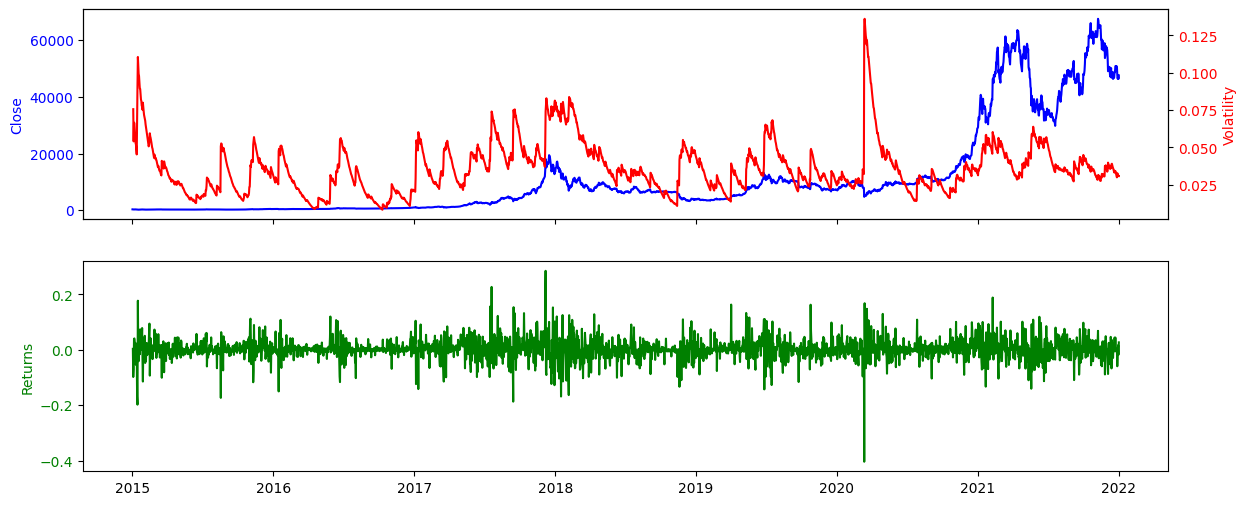

In [21]:
price_df['returns'] = price_df['close'].pct_change()

# Create a new figure with two subplots
fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, figsize=(14, 6))

# Plot 'close' on the primary y-axis of the first subplot
ax1.plot(price_df.index, price_df['close'], color='blue')
ax1.set_ylabel('Close', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for 'volatility' on the first subplot
ax2 = ax1.twinx()
ax2.plot(price_df.index, price_df['volatility'], color='red')
ax2.set_ylabel('Volatility', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Plot 'returns' on the second subplot
ax3.plot(price_df.index, price_df['returns'], color='green')
ax3.set_ylabel('Returns', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# Show the plot
plt.show()

In [4]:
# Define the parameter grid
param_grid = {
    'volatility_period': [8, 9, 10, 11, 12, 13, 14, 15],
    'upper_barrier_factor': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
    'lower_barrier_factor': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
    'vertical_barrier': [8, 9, 10, 11, 12, 13, 14, 15],
    'barrier_type': ['volatility'],
    'touch_type': ['HL']
}

In [5]:
# Optimize parameters every six months
optimized_params_df = optimize_parameters(price_df, param_grid, initial_capital=100000, num_starts=100, optimization_interval="6M")
# Apply the optimized parameters to label the data
labeled_df = pd.DataFrame()
for _, row in optimized_params_df.iterrows():
    start, end, params = row['start'], row['end'], row['params']
    interval_df = price_df.loc[start:end]
    labeler = TripleBarrierLabeler(**params)
    labeler.fit(interval_df)
    labeled_interval_df = labeler.transform()
    labeled_df = pd.concat([labeled_df, labeled_interval_df])

# Check the label distribution
print(labeled_df.label.value_counts(), optimized_params_df.sharpe_ratio)

Optimizing:   0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'buy_and_hold' is not defined

In [62]:
def plot_labels(price_series, labels):
    """
    Plot price series with bullish and bearish areas.
    
    Parameters:
    - price_series: A pandas Series of prices.
    - labels: A pandas Series of labels (-1, 0, 1).
    """
    # Create a new figure
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()
    
    # Plot the price series
    ax1.plot(price_series.index, price_series.values, label='Price', color='blue')
    
    # Draw a box for each window
    for label in labels:
        # Shift "from" and "to" by half a day
        from_timestamp = label["from"] - DateOffset(hours=12)
        to_timestamp = label["to"] + DateOffset(hours=12)
        
        # Ensure the timestamps are within the price series index
        from_timestamp = max(from_timestamp, price_series.index[0])
        to_timestamp = min(to_timestamp, price_series.index[-1])
        
        # Add the band
        ax2.fill_betweenx(ax1.get_ylim(), from_timestamp, to_timestamp, color='green' if label["label"] == 2 else "red" if label["label"] == 0 else 'white' , alpha=0.3)

    # Add a legend
    ax1.legend()
    
    # Show the plot
    plt.show()

In [63]:
def band_generator(labels):
    bands = [{'label': labels.iloc[0], 'from': labels.index[0]}]
    for l, i in enumerate(labels):
        if i == bands[-1]["label"]:
            pass
        else:
            bands[-1]["to"] = labels.index[l]
            # Check if l + 1 is within the range of the labels' indices
            if l + 1 < len(labels):
                bands.append({'label': i, 'from': labels.index[l + 1]})
    
    # Check if the last band has a 'to' field
    if 'to' not in bands[-1]:
        bands[-1]['to'] = labels.index[-1]
    
    return bands

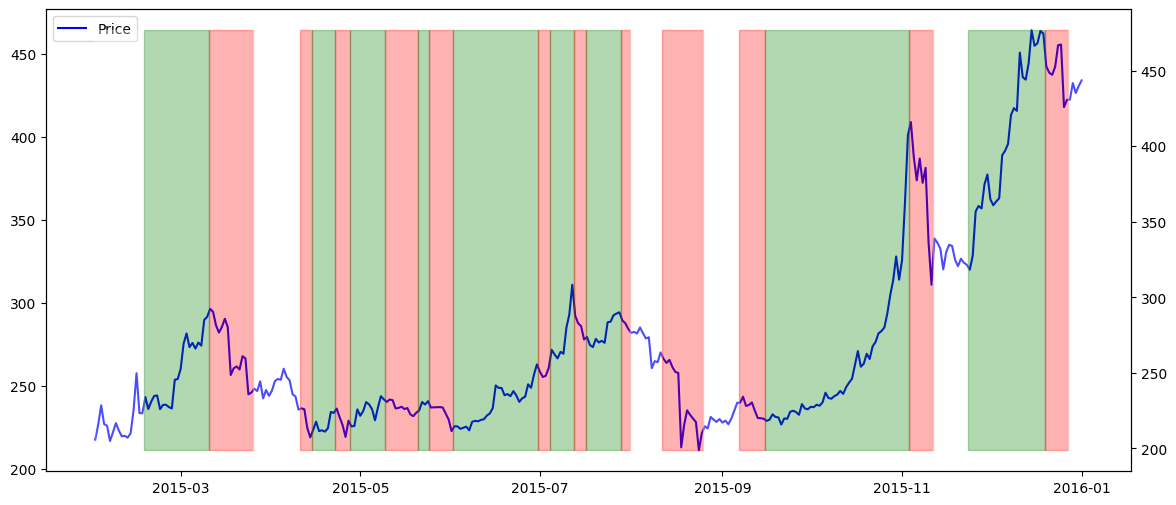

In [73]:
plt_df = labeled_df["2015-01-01": "2016-01-01"]
bands = band_generator(plt_df.label)
plot_labels(plt_df.close, bands)